In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
import Basis
import sys
from tqdm import tnrange

# Patch Processing Functions

In [3]:

def read_Patch_file(file_path):

    """Read the patch file and load the NURBS information

    Args:
        file_path (str): Path to file with the NURBS patch information

    Returns:
        dict: Dictionary with the patch information
    """

    patch_information = {}

    with open(file_path, "r") as fp:

        while True:

            line = fp.readline()
            if line == "":
                break;

            line = line.rstrip("\n")

            if "P(xi_order)" in line:
                P_value = int(line.split()[-1])
                patch_information["P"] = P_value

            if "Q(eta_order)" in line:
                Q_value = int(line.split()[-1])
                patch_information["Q"] = Q_value

            if "knots_xi" in line:
                num_knots = int(line.split()[-1])

                knot_vals = []
                for i in range(num_knots):
                    knot_vals.append(float(fp.readline().rstrip("\n")))

                patch_information["xiVector"] = knot_vals

            if "knots_eta" in line:
                num_knots = int(line.split()[-1])

                knot_vals = []
                for i in range(num_knots):
                    knot_vals.append(float(fp.readline().rstrip("\n")))

                patch_information["etaVector"] = knot_vals

            if "Control_Point_Data" in line:
                num_pts = int(line.split()[-1])

                pt_vals = []
                for i in range(num_pts):
                    pt_vals.append( [float(x) for x in fp.readline().rstrip("\n").split()])

                patch_information["Control_Point_List"] = pt_vals

            if "Control_Point_Connectivity" in line:
                line = line.split()

                num_xi = int(line[-2])
                num_eta = int(line[-1])

                connectivity_matrix = []
                for i in range(num_xi):
                    connectivity_matrix.append([int(x) for x in fp.readline().rstrip("\n").split()])

                patch_information["Connectivity_Matrix"] = connectivity_matrix


    # Create the control point net
    Control_Points_and_Weights = []

    numI = len(patch_information["Connectivity_Matrix"])
    numJ = len(patch_information["Connectivity_Matrix"][0])

    for i in range(numI):
        row_vals = []
        for j in range(numJ):
            pt_index = patch_information["Connectivity_Matrix"][i][j]
            row_vals.append(patch_information["Control_Point_List"][pt_index])
        Control_Points_and_Weights.append(row_vals)

    patch_information["Control_Points_and_Weights"] = Control_Points_and_Weights

    return patch_information


In [4]:

def plot_patch_points(case_patch_info, plot_points_xi_eta):

    """
    Plot the patch values

    Args:
        case_patch_info (dict): Dictionary with the information for the given patch
        case_data_tuple (tuple): Tuple holding the information for the given patch (used to
            determine the line color, linestyle, etc.)
        plot_points_xi_eta (list): List with the points (xi, eta) on the parametric 
            domain at which to plot the patch.

    Returns:
        TYPE: -
    """


    # Get the basis function lambda expressions
    R_pq = Basis.get_NURBS_basis_functions(case_patch_info["Control_Points_and_Weights"], 
        case_patch_info["P"], case_patch_info["Q"], case_patch_info["xiVector"], 
        case_patch_info["etaVector"])


    # Store the values of the basis functions at the required 
    # points on the knot domain. 
    numI, numJ = len(case_patch_info["Connectivity_Matrix"]), len(case_patch_info["Connectivity_Matrix"][0])

    basis_values = []

    for k in range(len(plot_points_xi_eta)):

        const_k_vals = []
        xi = plot_points_xi_eta[k][0]
        eta = plot_points_xi_eta[k][1]

        for i in range(numI):
            const_i_vals = []
            for j in range(numJ):
                const_i_vals.append(R_pq[i][j](xi, eta))

            const_k_vals.append(const_i_vals)

        basis_values.append(const_k_vals)


    x_vals, y_vals = [], []

    for pt_k in range(len(basis_values)):

        x, y = 0., 0.

        for i in range(numI):
            for j in range(numJ):

                x += basis_values[pt_k][i][j] * case_patch_info["Control_Points_and_Weights"][i][j][0]
                y += basis_values[pt_k][i][j] * case_patch_info["Control_Points_and_Weights"][i][j][1]

        x_vals.append(x)
        y_vals.append(y)

    plt.plot(x_vals, y_vals)

    x_scatter, y_scatter = [], []

    for i in range(numI):
        for j in range(numJ):
            x_scatter.append(case_patch_info["Control_Points_and_Weights"][i][j][0])
            y_scatter.append(case_patch_info["Control_Points_and_Weights"][i][j][1])

    plt.scatter(x_scatter, y_scatter, s=15)


# Airfoil Functions

In [5]:

def airfoil_parametric_equation(s, airfoil_function):

    """
    Get the coordinates of the airfoil (x,y) based on the 
    parametric coordinate s. s is an element of [-1, 1], and will
    go from the trailing edge, through the lower surface of the airfoil
    to the leading edge (s = 0) and back over the upper surface.
    The x limit of the airfoil is from -0.5 to 0.5. 

    :param s: The parametric coordinate

    :return: A tuple for the x and y coordinate for the point on the
        airfoil
    """

    if s >= -1 and s <= 0:
        x_by_c = -1*s

        x = x_by_c*1.0 + -0.5  # Chord length  = 1.0
        y = airfoil_function(x_by_c)[1]

    else:
        x_by_c = s

        x = x_by_c*1.0 + -0.5  # Chord length  = 1.0
        y = airfoil_function(x_by_c)[0]

    return (x,y)


def NACA_equation(x_by_c, airfoil_type_str):

    """
    Get the top and bottom y value for the given airfoil by
    using the NACA Airfoil equations. 

        m = The max value of the mean line in hundreths of chord
        p = The chordwise position of the maximum chamber in tenths
            of chord
        t = Max thickness normalized by the chord length

    :param x_by_c: The normalized location (by chord length) to
        evaluate properties at

    :return : Tuple containing the top and bottom location of the 
        airfoil surface at the given chord length point. 
        (top_y_value, bottom_y_value)
    """

    if airfoil_type_str == "NACA0012":
        m = 0.0
        p = 0.0
        t = 0.12
    elif airfoil_type_str == "NACA4412":
        m = 0.04
        p = 0.4
        t = 0.12
    else:
        raise ValueError("Not Supported Airfoil")

    x = x_by_c

    # Calculate y_c
    y_c = 0
    if not (p == 0 and m == 0):
        if x < p:
            y_c = (m/(p**2.))*(2.*p*x - x**2.)
        else:
            y_c = (m/((1.-p)**2.))*(1. - 2.*p + 2.*p*x - x**2.)

    # Calculate y_t

    a0 = 1.4845
    a1 = -0.6300
    a2 = -1.7580
    a3 = 1.4215
    a4 = -0.5180

    y_t = (t/1.0)*(a0*math.sqrt(x) + a1*x + a2*x**2. + a3*x**3. + a4*x**4.)

    return y_c + y_t, y_c - y_t

def plot_airfoil(airfoil_parametric_equation):

    # Test method for plotting airfoil

    s = np.linspace(-1, 1, 201)

    x_vals = []
    y_vals = []

    for s_val in s:
        pt = airfoil_parametric_equation(s_val)
        x_vals.append(pt[0])
        y_vals.append(pt[1])

    plt.plot(x_vals, y_vals, c='k', linestyle='--')


In [6]:

NACA0012_equation = lambda x_by_c: NACA_equation(x_by_c, "NACA0012")
NACA0012_parametric_equation = lambda s: airfoil_parametric_equation(s, NACA0012_equation)


# Plotting Comparisons

In [7]:

# The points (on the knot domain) to plot
airfoil_NURBS_domain_pts = []
t_vals = np.linspace(-1., 1., 100)
for t in t_vals:
    airfoil_NURBS_domain_pts.append((t, -1.))


In [18]:

patch_file = "geometry_parameters_airfoil_P5_NumPtsXi17_Q1_NumPtsEta2.geo"
patch_information = read_Patch_file(patch_file)


<IPython.core.display.Javascript object>


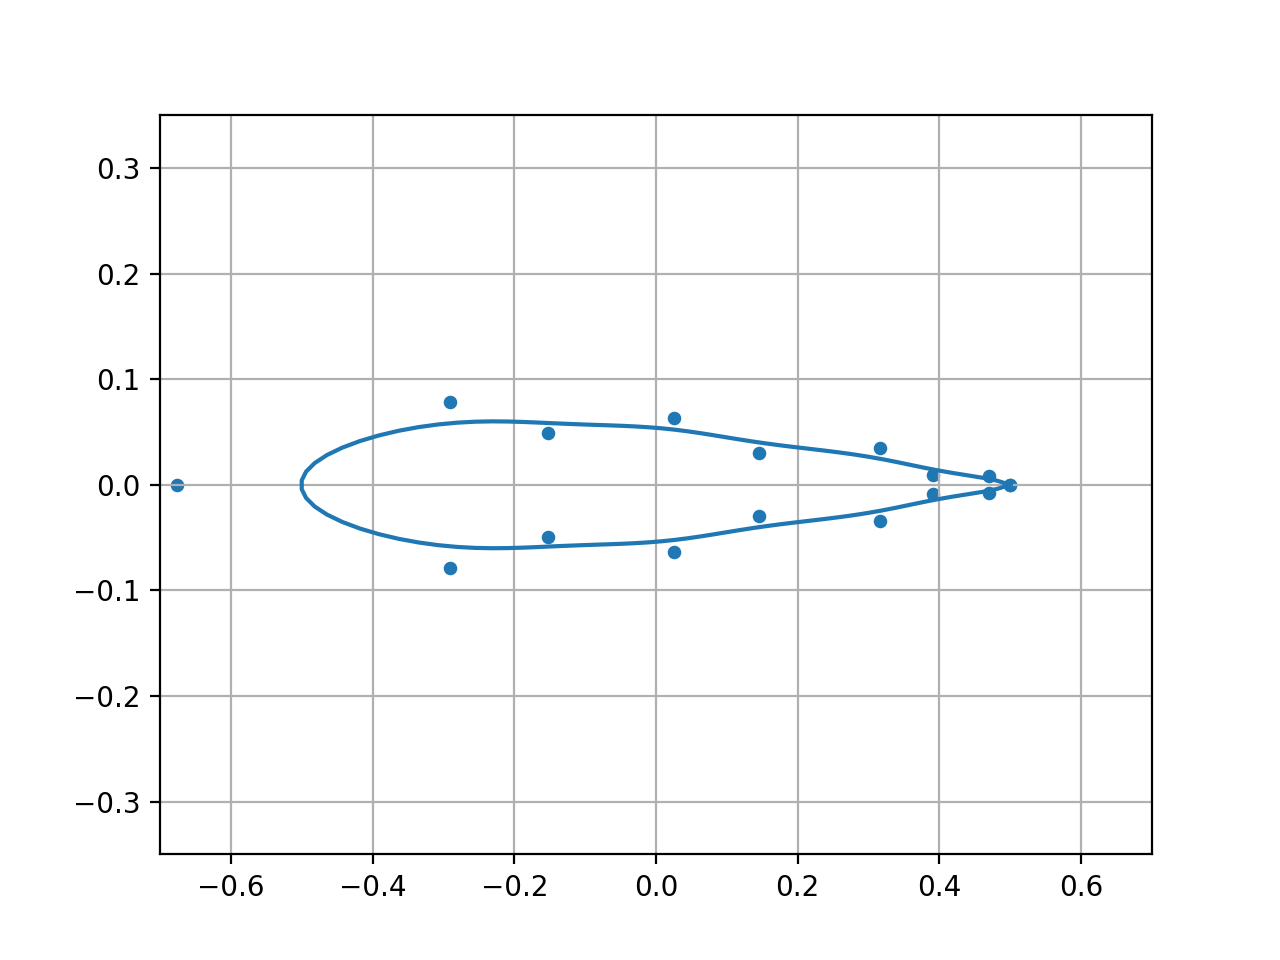

In [23]:

plot_patch_points(patch_information, airfoil_NURBS_domain_pts)

#plot_airfoil(NACA0012_parametric_equation)

plt.xlim([-0.7, 0.7])
plt.ylim([-0.35, 0.35])

plt.grid()